# Analysis

Let's first try Word Mover's Distance with Glove vectors using Gensim

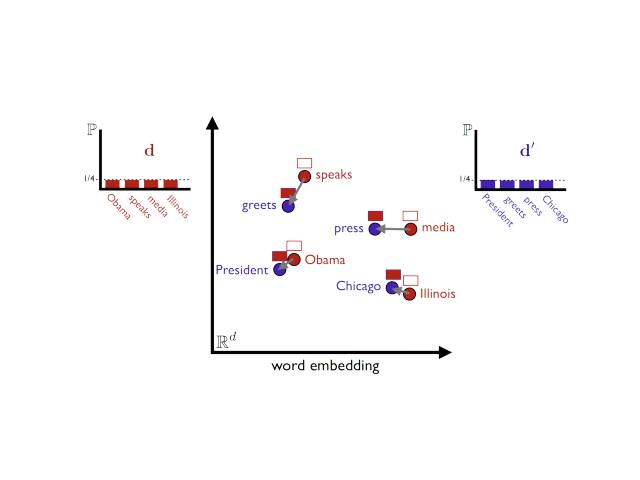

In [ ]:
import gensim
from gensim.models import KeyedVectors

GLOVE = '../data/glove.840B.300d.txt'

# Takes a few minutes
model = gensim.models.KeyedVectors.load_word2vec_format(GLOVE, binary=False, no_header=True)

In [ ]:
import pandas as pd
df = pd.read_csv('../data/recall_mood_data.csv', index_col=0)
df

In [ ]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

def preprocess(sentence):
    return [w for w in sentence.lower().split() if w not in stop_words]

In [12]:
from tqdm import tqdm
tqdm.pandas()

def calc_wmd(row):
    convo = preprocess(row['convos'])
    recall = preprocess(row['recalls'])
    wmd = model.wmdistance(convo, recall)
    return wmd

In [13]:
df['wmd'] = df.progress_apply(calc_wmd, axis=1)

100%|██████████| 118/118 [05:45<00:00,  2.93s/it]


In [18]:
df.head(1)

,Date,Experimenter,Subject Initials,SubjectID,ConditionExpt,ConditionSub,Credit,Notes,convos,recalls,wmd
0,2018-11-30 00:00:00,Evgeniia,JM,1,Incongruent,Happy,1,NaN,I'm Spencer by the way I'm Jake Nice to meet y...,We can start with living in Nashville I live ...,0.527173


# Results

There is no evidence that mood has an effect on the word mover's distance between conversation transcript and recall transcript.

In [6]:
from scipy import stats

stats.spearmanr(df['ConditionSub'], df['wmd'])

SpearmanrResult(correlation=-0.060457262399629196, pvalue=0.5154738086871496)

# Follow-up

These are obviously not the results we were hoping for.

Let's double check that Word Mover's Distance can at least "retrieve" the correct transcript using a nearest neighbor search. This will confirm that word mover's distance can measure information overlap between conversation and recall texts.

In [15]:
from gensim.similarities import WmdSimilarity

index = WmdSimilarity(df['convos'], model, num_best=10)

In [17]:
# index[recalls['4']]
index[df.loc[55]['recalls']]

[(92, 0.9365312314885856),
 (93, 0.9365312314885856),
 (9, 0.9299069562847591),
 (8, 0.9299069562847591),
 (17, 0.9263625175847283),
 (16, 0.9263625175847283),
 (3, 0.9261705135053667),
 (2, 0.9261705135053667),
 (55, 0.9252291069706817),
 (54, 0.9252291069706817)]

In [ ]:
for k, v in tqdm(recalls.items()):
    wmd = model.wmdistance(convos[k].lower().split(), v.lower().split())
    wmd_dict[k] = wmd